In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import glob
import os
from matplotlib import cm
import dask
import pickle
import matplotlib as mpl
from matplotlib.markers import MarkerStyle


In [2]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [3]:
final_models = list(pd.read_csv('../../scores/results.csv').set_index('Model').index)
final_models = [model for model in final_models if model not in ['ERA5' , 'NOAA']]

winners = ['MIROC-ESM-CHEM','BNU-ESM','CNRM-CM5','GFDL-ESM2M','bcc-csm1-1','ACCESS1-0']
winners = [i for i in winners if i in final_models]

In [4]:
def get_mean(dic):
    return (dic['JJA']+dic['SON']+dic['MAM']+dic['DJF'])/4

In [5]:
rcp85_high = pickle.load( open("../HIGH/rcp85_dic.p", "rb"))
hist_high =  pickle.load( open("../HIGH/hist_dic.p", "rb"))

rcp85_jet = pickle.load( open("../JET/rcp85_dic.p", "rb"))
hist_jet =  pickle.load( open("../JET/historical_dic.p", "rb"))

In [6]:
pr_dic = pickle.load(open("../pr/monthly_pr_dic.p", "rb"))

In [7]:
tas_dic = pickle.load(open("../tas/monthly_tas_dic.p", "rb"))

In [8]:
vmin = []
vmax = []
for model in winners:
    High_final = (get_mean(rcp85_high[model]) - get_mean(hist_high[model]))
    vmin.append(np.min(High_final.values))
    vmax.append(np.max(High_final.values))

    
vmin_high = np.min(vmin)
vmax_high = np.max(vmax)

norm_high = MidpointNormalize(vmin=vmin_high, vmax=vmax_high, midpoint=0)

In [9]:
vmin = []
vmax = []
for model in final_models:
    Jet = (rcp85_jet[model].mean(dim='time') - hist_jet[model].mean(dim='time'))
    vmin.append(np.min(Jet.values))
    vmax.append(np.max(Jet.values))
    
vmin_jet = np.min(vmin)
vmax_jet = np.max(vmax)

norm_jet = MidpointNormalize(vmin=vmin_jet, vmax=vmax_jet, midpoint=0)

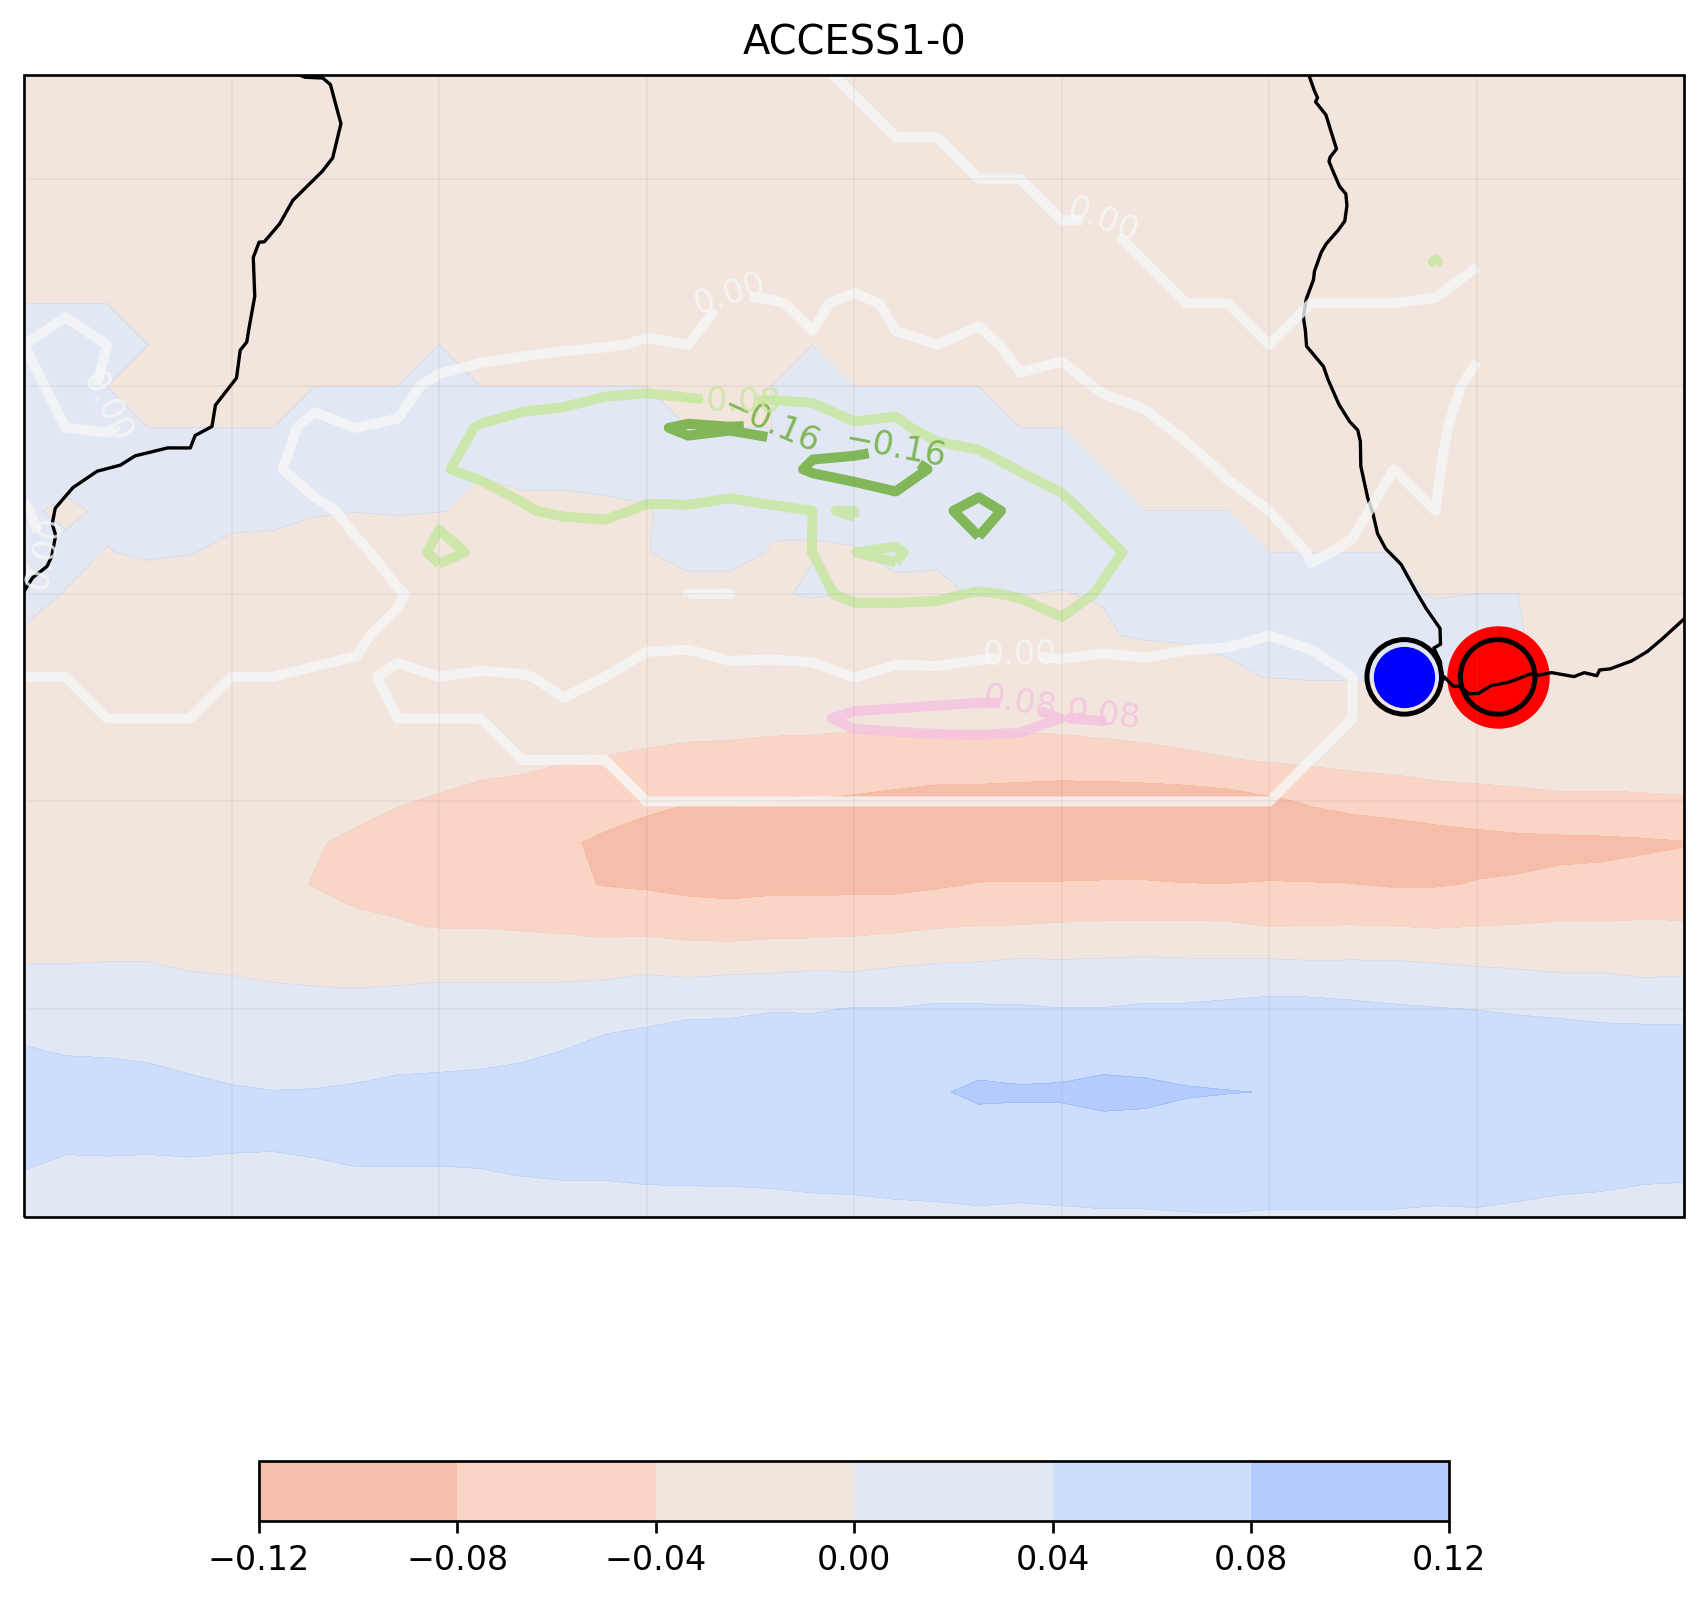

In [18]:
#for model in final_models:
for model in ['ACCESS1-0']:
    Jet_final = (rcp85_jet[model].mean(dim='time') - hist_jet[model].mean(dim='time'))
    High_final = (get_mean(rcp85_high[model]) - get_mean(hist_high[model]))
    fig = plt.figure(figsize=(16,9), dpi = 240)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    cmap = 'coolwarm_r'
    j = ax.contourf(Jet_final.lon,Jet_final.lat,Jet_final,  cmap = cmap, norm = norm_jet, vmin = vmin_jet, vmax = vmax_jet, transform = ccrs.PlateCarree(),levels = 5, alpha =0.6)
    cmap = 'PiYG_r' 
    c = ax.contour(High_final.lon,High_final.lat,High_final,cmap=cmap, norm = norm_high, vmin = vmin_high, vmax = vmax_high, transform = ccrs.PlateCarree(),levels = 4, linewidths = 3, alpha = 0.8)
    ax.clabel(c, c.levels, inline=True, fontsize=10)
    plt.title(str(model))
    plt.colorbar(j, shrink = 0.4, orientation = 'horizontal')
    ax.gridlines(linewidth=0.5, color='gray', alpha=0.1)
    ax.set_extent([-50, 30, -60, -5], ccrs.PlateCarree())
    ax.scatter(y = -34,x = 16.5 , s = (500 + (1.3e8* (pr_dic[model].sel(time = slice('2045','2100')).mean(dim = 'time').values) - (pr_dic[model].sel(time = slice('1950','2005')).mean(dim = 'time').values))), color = 'blue', alpha = 1)
    ax.scatter(y = -34,x = 16.5 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
    ax.scatter(y = -34,x = 21, s = (500 + (1.7e2 *(tas_dic[model].sel(time = slice('2045','2100')).mean(dim = 'time').values) - (tas_dic[model].sel(time = slice('1950','2005')).mean(dim = 'time').values))), color = 'red', alpha = 1)
    ax.scatter(y = -34,x = 21 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
    plt.savefig('Plots/'+str(model)+'_combo.png', dpi = 240)
    plt.savefig('Plots/'+str(model)+'_combo.pdf')
    #plt.close()
    plt.show()

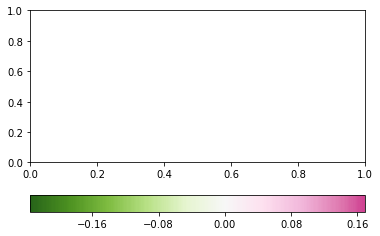

In [19]:
sm = plt.cm.ScalarMappable(norm=norm_high, cmap = c.cmap)
sm.set_array([])
plt.colorbar(sm, ticks=c.levels, orientation = 'horizontal')
plt.savefig('Plots/High_cbar_combo.pdf')

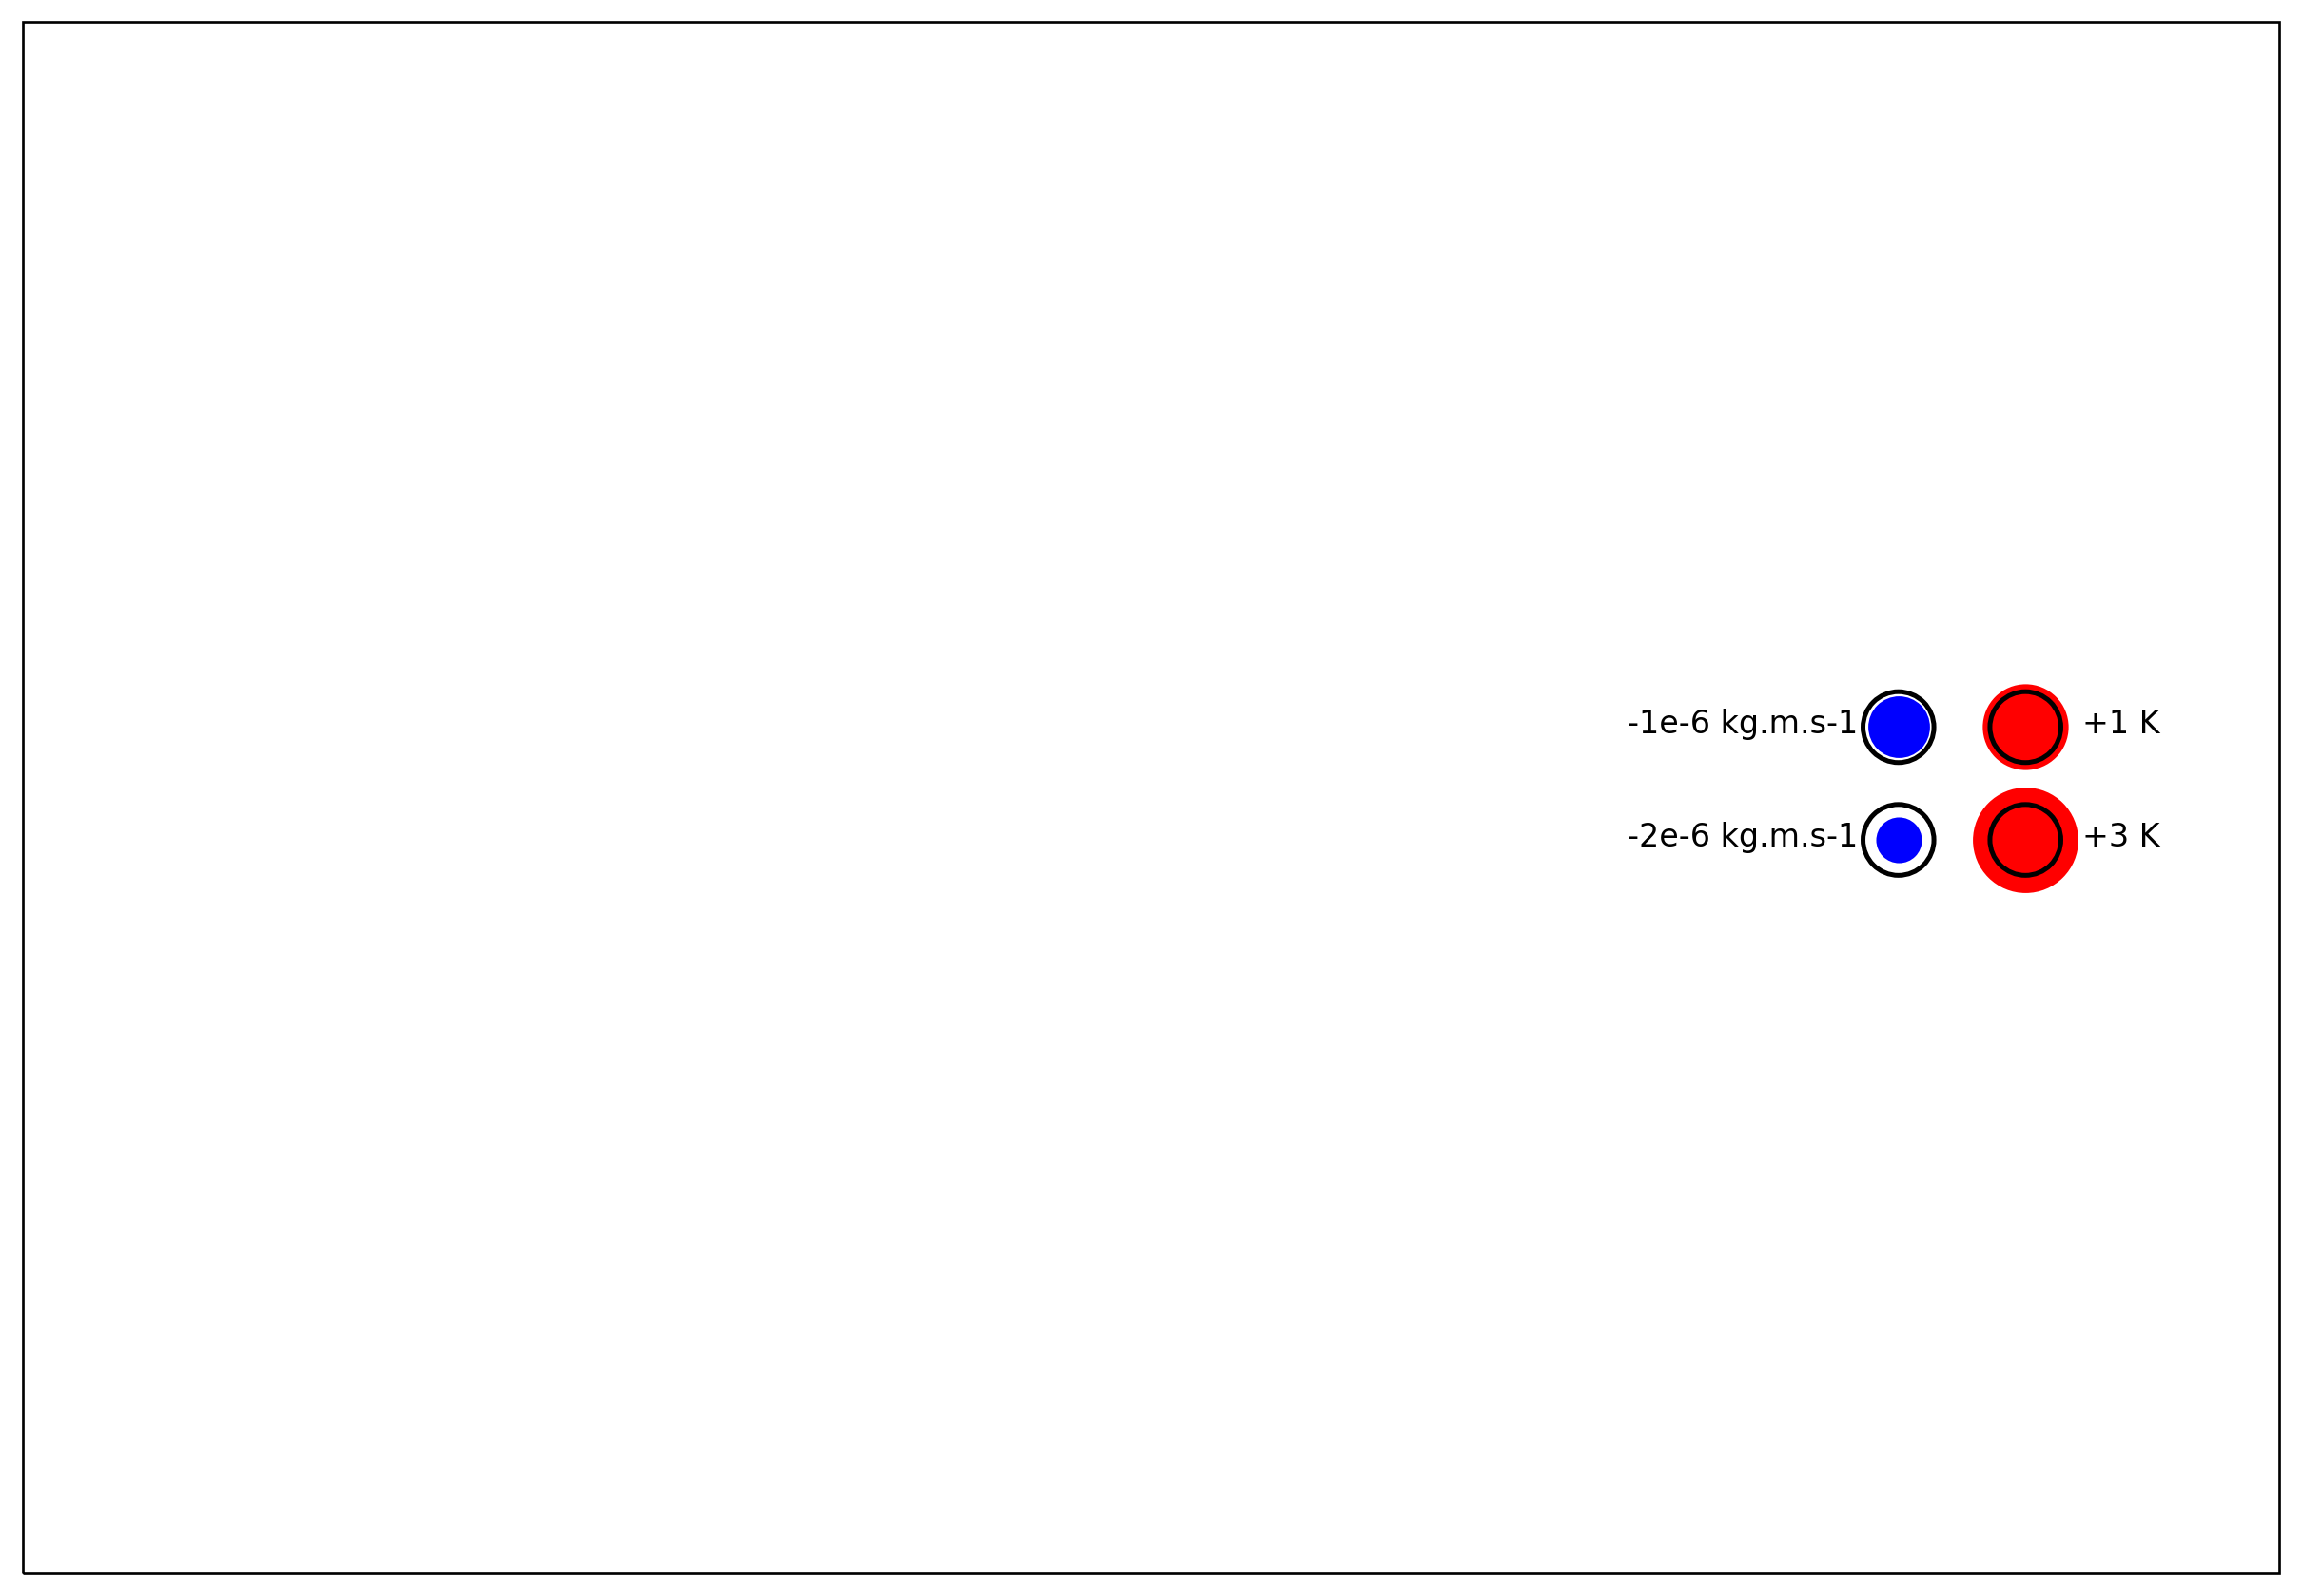

In [20]:
fig = plt.figure(figsize=(16,9), dpi = 240)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(y = -34,x = 16.5 , s = (500 + (1.6e8* (-2e-06))), color = 'blue', alpha = 1)
ax.scatter(y = -34,x = 16.5 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
ax.annotate(xy = [6.9,-34.2] , text = '-2e-6 kg.m.s-1')

ax.scatter(y = -34,x = 21, s = (500 + (1.8e2 *(3))), color = 'red', alpha = 1)
ax.scatter(y = -34,x = 21 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
ax.annotate(xy = [23,-34.2] , text = '+3 K')

ax.scatter(y = -30,x = 16.5 , s = (500 + (-1.6e8* 1e-06)), color = 'blue', alpha = 1)
ax.scatter(y = -30,x = 16.5 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
ax.annotate(xy = [6.9,-30.2] , text = '-1e-6 kg.m.s-1')

ax.scatter(y = -30,x = 21, s = (500 + (1.8e2 *(1))), color = 'red', alpha = 1)
ax.scatter(y = -30,x = 21 , s = 500, color = 'black' , alpha = 1, marker = MarkerStyle('o', fillstyle = 'none'))
ax.annotate(xy = [23,-30.2] , text = '+1 K')

ax.set_extent([-50, 30, -60, -5], ccrs.PlateCarree())

plt.savefig('Plots/keys.pdf')
plt.show()